In [24]:
import csv
from pathlib import Path
import os
from matplotlib import pyplot as plt
import numpy as np
import torch
import gpytorch
import glob
from tqdm.notebook import tqdm
import os
from numpy import genfromtxt
import time
import scipy
import pandas as pd

torch.__version__



'1.13.0+cu117'

In [25]:
#              0       1      2    3     4     5    6    7      8     9       10       11        12
#           safety throttle steer curr volt   ax   ay    w    v_enc  time   x_opti   y_opti  theta_opti
train_inputs_indexes = [ 1, 2, 5, 6, 7 ]
train_outputs_indexes = [ 5, 6, 7]

# filtering data parameters

dt = 0.1
time_step = 0.1

# Length of the Jetracer
L = 0.175   
m = 1.63
Iz = 0.0061
lr = 0.45*L
lf = L - lr
dt = 0.1

# Plot Data in order to find similar batches

# LOAD TRAIN DATA

In [34]:
address_to_folder = Path(str(Path(os.getcwd())) + '/GP_MPCC_data_recordings')
# batch con basse velocità su cui fare training
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_41_22.csv')
file_name_train = Path( str(address_to_folder) + '/rec_mod_17_41_22.csv')

# batch per fare training ad alte velocità
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_36_04.csv')

# batch basse velocità donut
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_45_42.csv')

# batch molto lungo
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_30_18.csv')



data_numpy_train = genfromtxt(file_name_train, delimiter=',', skip_header=1)

# if file_name_train == Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_36_04.csv'):
#     data_numpy_train = data_numpy_train[:1000,:]

# data_numpy_train = data_numpy_train[:700,:]

if np.mod(data_numpy_train.shape[0],2)!=0:
    data_numpy_train = data_numpy_train[:-1,:]


# LOAD TEST DATA

In [35]:
# batch con velocità comparabili al training
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_16_41.csv')

# batch con velocità molto più alte
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_53_07.csv')

# batch alte velocità donut
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_49_27.csv')

# batch con velocità MEDIO-ALTA
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_36_04.csv')

# batch molto lungo
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_30_18.csv')
file_name_test = Path( str(address_to_folder) + '/rec_mod_17_30_18.csv')


data_numpy_test = genfromtxt(file_name_test, delimiter=',', skip_header=1)

# if file_name_test == Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_53_07.csv'):
#     data_numpy_test = data_numpy_test[:300,:]
    
# if file_name_test == Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_36_04.csv'):
#     data_numpy_test = data_numpy_test[:1000,:]


    
# data_numpy_test = data_numpy_test[100:700,:]

if np.mod(data_numpy_test.shape[0],2)!=0:
    data_numpy_test = data_numpy_test[:-1,:]


# EXTRACT AND CONVERT DATA

In [36]:
#        0        1       2           3          4            5        6           7       8      9       10      11       12     13  14    15      16           17              18    
# elapsed time, opti x, opti y, opti theta, safety_value, throttle, steering, current, voltage, IMU[0], IMU[1], IMU[2], endocder, vx, vy, omega,total comp time,solver comp time

t_train = data_numpy_train[:,0]
X_train = data_numpy_train[:,1]
Y_train = data_numpy_train[:,2]
theta_train = data_numpy_train[:,3]
safety_train = data_numpy_train[:,4]
tau_train = safety_train*data_numpy_train[:,5]

steer_train = -data_numpy_train[:,6]*18.85/180*np.pi # THE SIGN IS OPPOSITE TO THE ONE SENT TO THE JETRACER

vx_train = data_numpy_train[:,13] # LOCAL
vy_train = data_numpy_train[:,14] # LOCAL
w_train = data_numpy_train[:,15]

w_train_opti = np.gradient(theta_train, time_step)
N_train = data_numpy_train.shape[0]

# for i in range(N_train):
#     if abs(w_train_opti[i])>8:
#         w_train_opti[i] = w_train_opti[i-1]
        
vx_mean_train = np.mean(vx_train)       
print('mean v_x: ', vx_mean_train)


mean v_x:  0.5075750877890636


In [17]:
#        0        1       2           3          4            5        6           7       8      9       10      11       12     13  14    15      16           17              18    
# elapsed time, opti x, opti y, opti theta, safety_value, throttle, steering, current, voltage, IMU[0], IMU[1], IMU[2], endocder, vx, vy, omega,total comp time,solver comp time

t_test = data_numpy_test[:,0]
X_test = data_numpy_test[:,1]
Y_test = data_numpy_test[:,2]
theta_test = data_numpy_test[:,3]
safety_test = data_numpy_test[:,4]
tau_test = safety_test*data_numpy_test[:,5]
tau_pre_test = np.hstack((0,tau_test[:-1]))
steer_test = -data_numpy_test[:,6]*18.85/180*np.pi
steer_pre_test = np.hstack((0,steer_test[:-1]))
vx_test = data_numpy_test[:,13]
vy_test = data_numpy_test[:,14]
w_test = data_numpy_test[:,15]

w_test_opti = np.gradient(theta_test, time_step)
N_test = data_numpy_test.shape[0]

# for i in range(N_test):
#     if abs(w_test_opti[i])>8:
#         w_test_opti[i] = w_test_opti[i-1]
        
vx_mean_test = np.mean(vx_test)       
print('mean v_x: ', vx_mean_test)       


mean v_x:  0.6893921512549948


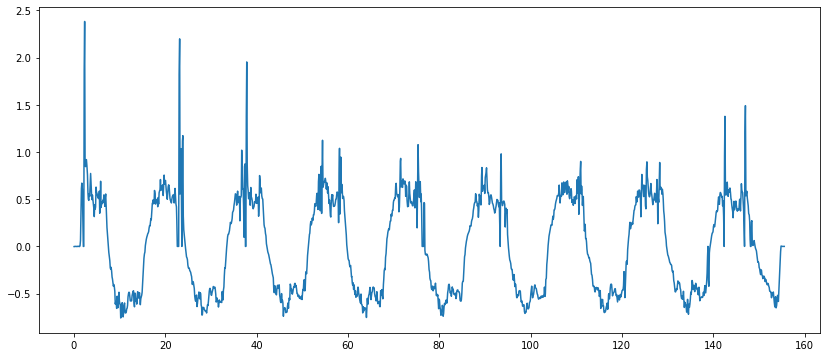

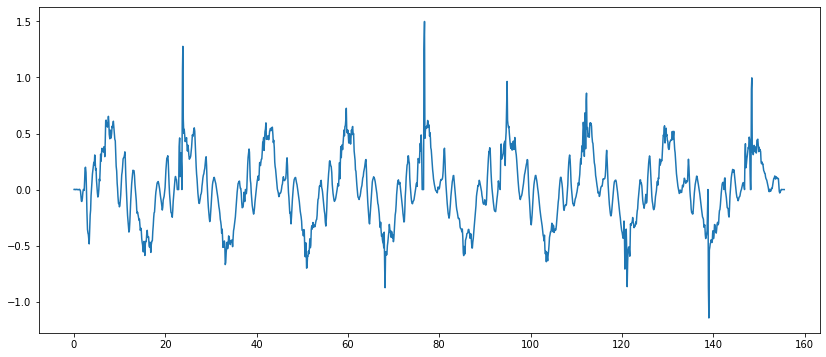

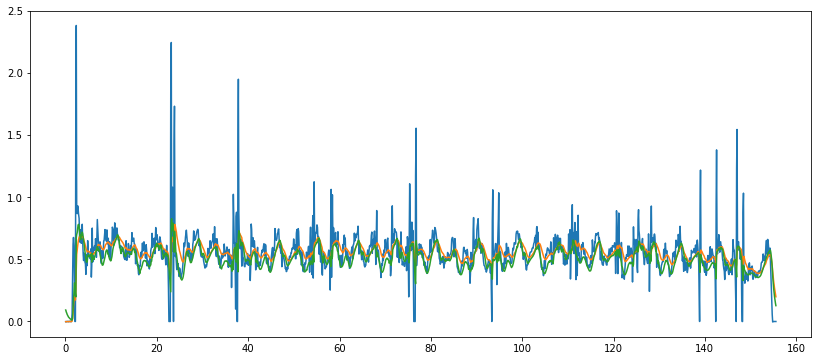

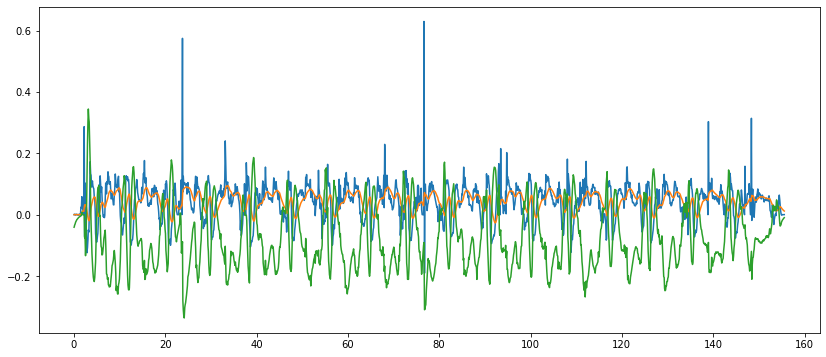

In [18]:
from numpy.fft import rfft, irfft, rfftfreq

def low_pass(s,cut_off_freq, time_step):
    fourier = rfft(s)
    f = rfftfreq(s.size, d=time_step)
    fourier = fourier * np.ones(len(f)) * cut_off_freq/(f + cut_off_freq)
    return irfft(fourier)

def discrete_lp(x, omega_c, T):
    
    N = len(x)
    y = np.zeros((N))
    y[0] = x[0]
    alpha = (2 - T * omega_c) / (2 + T * omega_c)
    beta = T * omega_c / (2 + T * omega_c)
    for k in range(1, N):
        y[k] = alpha * y[k - 1] + beta * (x[k] + x[k - 1])
    return y
   
# DERIVE GLOBAL SPEED FROM OPTITRACK
vX_train = np.gradient(X_train, t_train)
vY_train = np.gradient(Y_train, t_train)
# DERIVE LOCAL SPEED
vx_prova_train = vX_train*np.cos(theta_train) + vY_train*np.sin(theta_train)
vy_prova_train = -vX_train*np.sin(theta_train) + vY_train*np.cos(theta_train)

vx_prova_train_old = vx_prova_train
vy_prova_train_old = vy_prova_train



## DELETE THE SPIKES
# idx_x = []
# for ii in range(1, len(vx_prova_train)):
#     if (abs(vx_prova_train[ii] - vx_prova_train[ii-1]) > 0.1):
# #         print(ii)
#         idx_x = [ *idx_x, ii]

# for k in idx_x:
    
#     if ( vx_prova_train[k] - vx_prova_train[k-1] ) > 0 :
#         vx_prova_train[k] = vx_prova_train[k-1] + 0.05
#     else :
#         vx_prova_train[k] = vx_prova_train[k-1] - 0.05
        
# idx_y = []
# for ii in range(1, len(vy_prova_train)):
#     if (abs(vy_prova_train[ii] - vy_prova_train[ii-1]) > 0.1):
# #         print(ii)
#         idx_y = [ *idx_y, ii]

# for k in idx_y:
    
#     if ( vy_prova_train[k] - vy_prova_train[k-1] ) > 0 :
#         vy_prova_train[k] = vy_prova_train[k-1] + 0.05
#     else :
#         vy_prova_train[k] = vy_prova_train[k-1] - 0.05
        
# discrete filter
# vx_pre_train_raw = 0
# vy_pre_train_raw = 0

# vx_pre_train_lf = 0
# vy_pre_train_lf = 0

# t_pre = 0


f = 1 #CUT OFF FREQUENCY
# FILTER DATA
vx_train_lf = discrete_lp(vx_prova_train, f, time_step)
vy_train_lf = discrete_lp(vy_prova_train, f, time_step)

# vx_train_lf = low_pass(vx_prova_train, fx, time_step)
# vy_train_lf = low_pass(vy_prova_train, fy, time_step)


# PLOT DATA
# GLOBAL VX
plt.figure(figsize=(14,6))
plt.plot(t_train, vX_train)
# GLOBAL VY
plt.figure(figsize=(14,6))
plt.plot(t_train, vY_train)
# LOCAL VX
plt.figure(figsize=(14,6))
plt.plot(t_train, vx_prova_train_old)
plt.plot(t_train, vx_train_lf)
plt.plot(t_train, vx_train)
# LOCAL VY
plt.figure(figsize=(14,6))
plt.plot(t_train, vy_prova_train)
plt.plot(t_train, vy_train_lf)
plt.plot(t_train, vy_train)


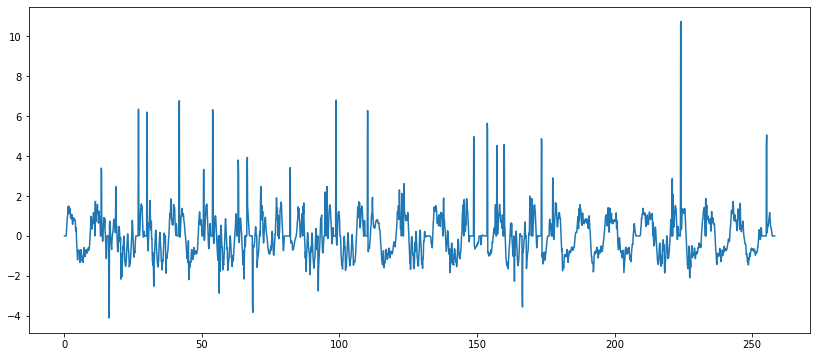

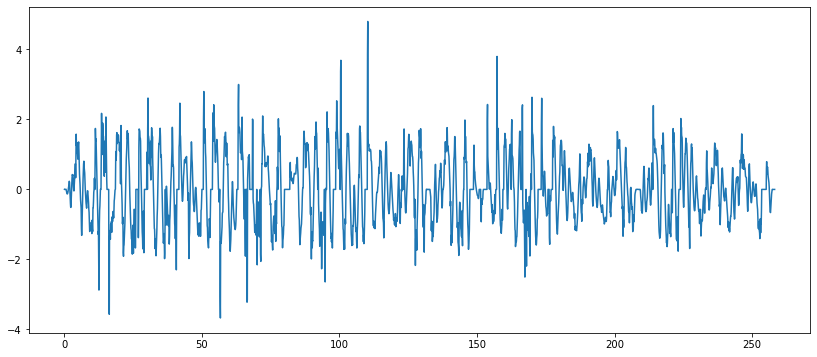

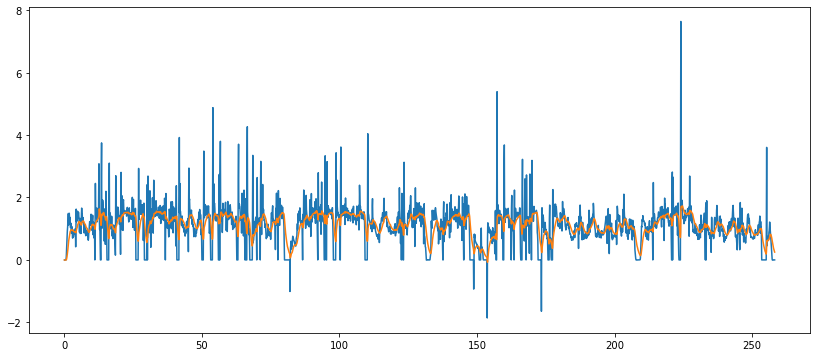

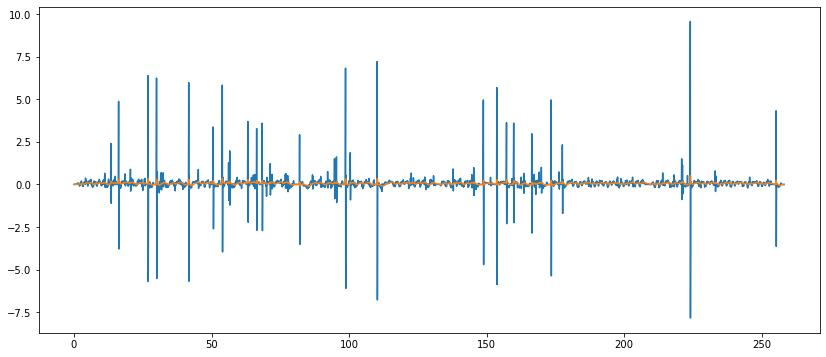

In [19]:
from numpy.fft import rfft, irfft, rfftfreq

def low_pass(s,cut_off_freq, time_step):
    fourier = rfft(s)
    f = rfftfreq(s.size, d=time_step)
    fourier = fourier * np.ones(len(f)) * cut_off_freq/(f + cut_off_freq)
    return irfft(fourier)

vX_test = np.gradient(X_test, t_test)
vY_test = np.gradient(Y_test, t_test)

vx_prova_test = vX_test*np.cos(theta_test) + vY_test*np.sin(theta_test)
vy_prova_test = -vX_test*np.sin(theta_test) + vY_test*np.cos(theta_test)

vx_test_lf = discrete_lp(vx_prova_test, f, time_step)
vy_test_lf = discrete_lp(vy_prova_test, f, time_step)
    

plt.figure(figsize=(14,6))
plt.plot(t_test, vX_test)

plt.figure(figsize=(14,6))
plt.plot(t_test, vY_test)


plt.figure(figsize=(14,6))
plt.plot(t_test, vx_prova_test)
plt.plot(t_test, vx_test_lf)


plt.figure(figsize=(14,6))
plt.plot(t_test, vy_prova_test)
plt.plot(t_test, vy_test_lf)



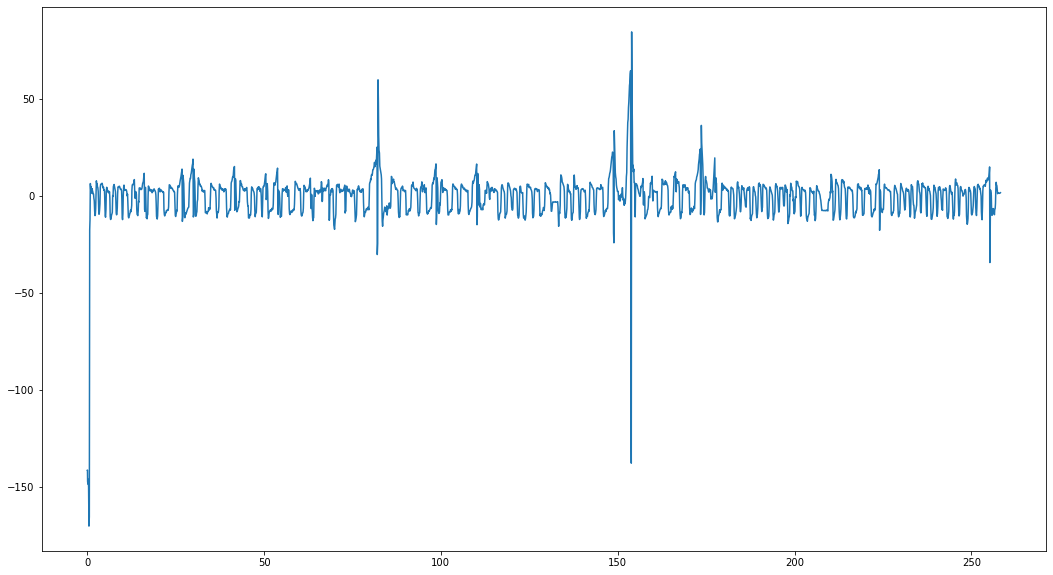

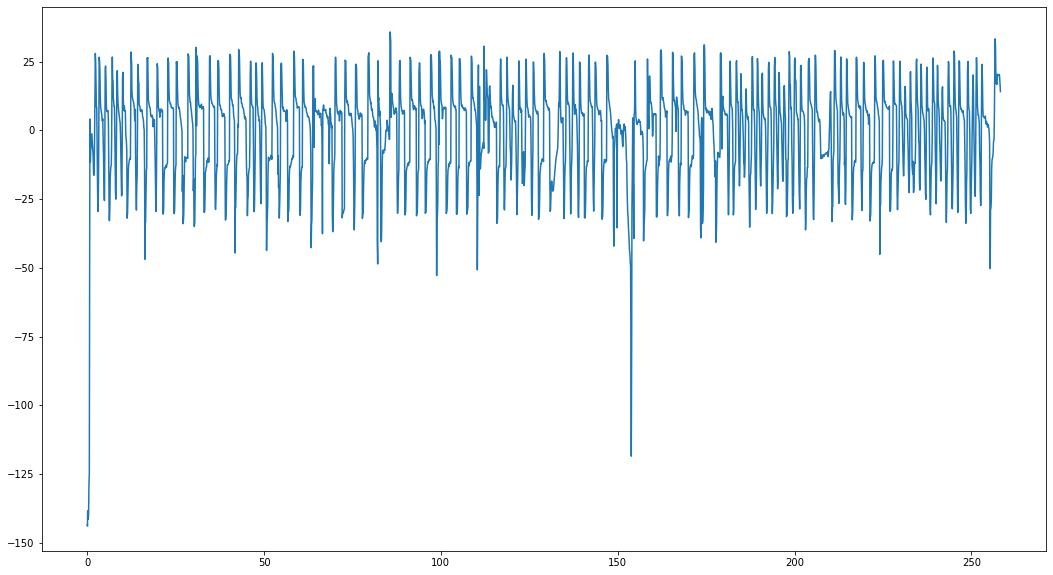

In [20]:
# SINCE I'VE FILTERED IN WRONG WAY THE DATA, NOW I HAVE TO SUB THE LOCAL SPEED COLLECTED IN LAB WITH LOCAL SPEED
# DERIVED ABOVE FROM OPTITRACK POSITION
vx_train = vx_train_lf
vy_train = vy_train_lf

vx_test = vx_test_lf
vy_test = vy_test_lf

alpha_r_test = np.arctan2( ( lr*w_test - vy_test ), vx_test)
alpha_f_test = steer_test - np.arctan2( lr*w_test + vy_test, vx_test )

plt.figure(figsize=(18,10))
plt.plot(t_test, alpha_r_test*180/np.pi)
plt.figure(figsize=(18,10))
plt.plot(t_test, alpha_f_test*180/np.pi)


#    # SAVE DATA for matlab fitting

In [21]:
# NOTE THAT I AM SAVING RAW DATA, NOT THE FILTERED ONE
data_1 = np.vstack((tau_train, steer_train, vx_prova_train, vy_prova_train, w_train, theta_train, w_train_opti))
# data_1 = np.vstack((tau_train, steer_train, vx_train, vy_train, w_train, theta_train, w_train_opti))
print(data_1.shape)
mdic1 = {'data1' : data_1, 'label': 'filt_Opti'}
data_2 = np.vstack((tau_test, steer_test, vx_prova_test, vy_prova_test, w_test, theta_test, w_test_opti))
# data_2 = np.vstack((tau_test, steer_test, vx_test, vy_test, w_test, theta_test, w_test_opti))
print(data_2.shape)
mdic2 = {'data1' : data_2, 'label': 'filt_Opti'}

scipy.io.savemat('matlab_data1_LOW_RAW.mat', mdic1)
scipy.io.savemat('matlab_data2_LUNGO_RAW.mat', mdic2)

(7, 1558)
(7, 2584)


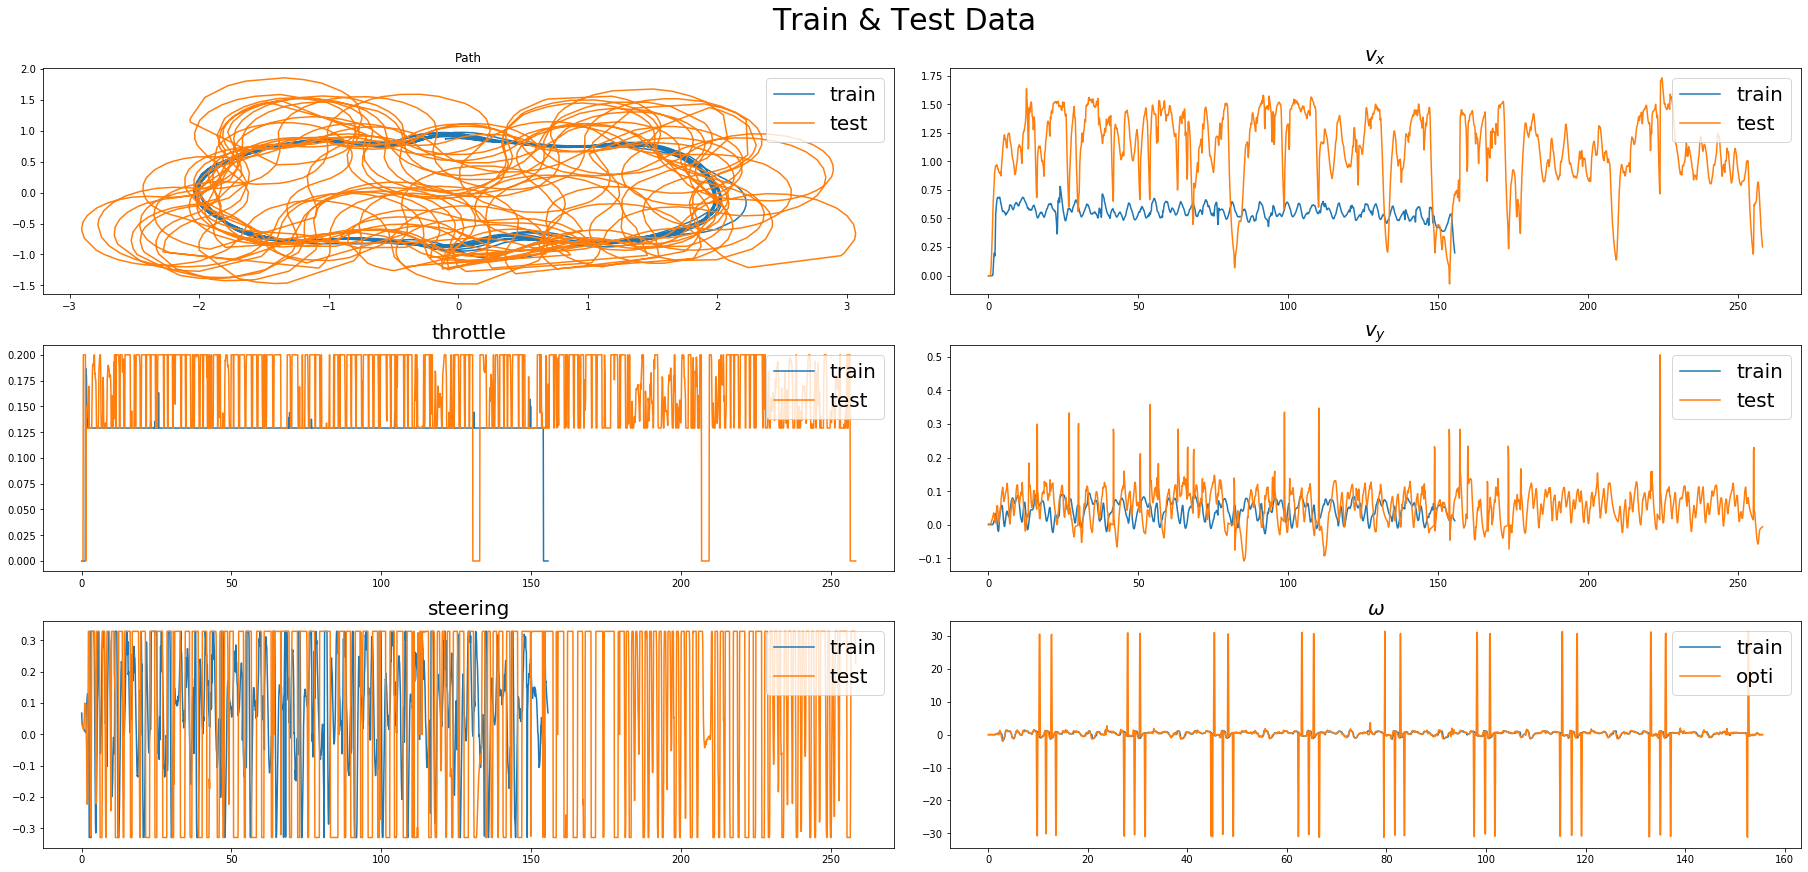

In [22]:
fig, ( (ax1, ax2), (ax3, ax4), (ax5, ax6) ) = plt.subplots(3, 2, figsize=(25, 12), constrained_layout=True)
fig.suptitle('Train & Test Data', fontsize=30)

ax1.set_title('Path')
ax1.plot(X_train, Y_train, label='train')
ax1.plot(X_test, Y_test, label='test')
ax1.legend(loc='upper right', fontsize=20)


# TAU
ax3.plot(t_train, tau_train, label='train')
ax3.plot(t_test, tau_test, label='test')
# plt.plot(t_train, data_numpy_train[:,5])
ax3.set_title('throttle', fontsize=20)
ax3.legend(loc='upper right', fontsize=20)

# STEER
ax5.plot(t_train, steer_train, label='train')
ax5.plot(t_test, steer_test, label='test')
ax5.set_title('steering', fontsize=20)
ax5.legend(loc='upper right', fontsize=20)

# LOCAL SPEED vx
ax2.plot(t_train, vx_train, label='train')
ax2.plot(t_test, vx_test, label='test')
# ax2.plot(t_train, v_train, label='norm train')
# ax2.plot(t_test, v_test, label='norm test')
# plt.plot(data_numpy_train[:,9], vx_train_lf)
ax2.set_title('$v_x$', fontsize=20)
ax2.legend(loc='upper right', fontsize=20)

# LOCAL SPEED vy
ax4.plot(t_train, vy_train, label='train')
ax4.plot(t_test, vy_test, label='test')
# plt.plot(data_numpy_train[:,9], vy_train_lf)
ax4.set_title('$v_y$', fontsize=20)
ax4.legend(loc='upper right', fontsize=20)
# plt.ylim((-1,1))

# OMEGA
ax6.plot(t_train, w_train, label='train')
ax6.plot(t_train, w_train_opti, label='opti')
# plt.plot(t_train, w_train_opti)
ax6.set_title('$\\omega$', fontsize=20)
ax6.legend(loc='upper right', fontsize=20)

# plt.savefig('pictures_4_thesis/sim/Train&Test_dataset.png',dpi=300)



# Overwrite raw data with filtered data

In [23]:
data_train = np.zeros((N_train,10))
data_train[:,0] = safety_train
data_train[:,1] = tau_train
data_train[:,2] = steer_train
data_train[:,3] = np.zeros(N_train)
data_train[:,4] = np.zeros(N_train)
data_train[:,5] = vx_train
data_train[:,6] = vy_train
data_train[:,7] = w_train
data_train[:,8] = tau_pre_train
data_train[:,9] = steer_pre_train

data_test = np.zeros((N_test,10))
data_test[:,0] = safety_test
data_test[:,1] = tau_test
data_test[:,2] = steer_test
data_test[:,3] = np.zeros(N_test)
data_test[:,4] = np.zeros(N_test)
data_test[:,5] = vx_test
data_test[:,6] = vy_test
data_test[:,7] = w_test
data_test[:,8] = tau_pre_test
data_test[:,9] = steer_pre_test

#              0       1      2    3     4     5    6    7      8     9       10       11        12
#           safety throttle steer curr volt   vx   vy    w    v_enc  time   x_opti   y_opti  theta_opti

NameError: name 'tau_pre_train' is not defined

# Define the nominal dynamics

In [ ]:
# def nominal_dynamics(par, throttle, delta_cmd, v_x, v_y, w):
    
#     L = par[0]
#     a = par[1]
#     b = par[2]
#     c = par[3]
#     d = par[4]
#     p1 = par[5]
#     p2 = par[6]
#     p3 = par[7]
#     dt = par[8]
    
#     v_enc = np.sqrt(v_x**2 + v_y**2)
#     delta = 0.3389*np.arctan2(1.461*delta_cmd,1)
        
# #     acc_x = a*(p1/np.pi*(torch.arctan(p2*throttle+p3)+np.pi/2)) - b*v_enc \
# #         *(p1/np.pi*(torch.arctan(p2*throttle+p3) + np.pi/2)) - c*v_enc - d 

#     a_mot = 5.69362507162820
#     b_mot = 0.741819300630959
#     c_mot = 0.144812936532940
    
# #     acc_x = 1.207*throttle - 0.0579*v_x - 1.262*delta**2 + 0.0579*delta
    
#     acc_x = a_mot*throttle - b_mot*v_x - c - 1.262*delta**2 + 0.0579*delta
    
#     acc_y = v_x*w
    
#     v_x_next = v_x + dt * acc_x
#     v_y_next = v_y + dt * acc_y
    
#     v_enc_next = np.sqrt(v_x_next**2 + v_y_next**2)
    
    
#     w_next =  -v_x_next * np.tan(delta) / L 
    
#     f_nom = torch.tensor([ [ v_x_next, v_y_next, w_next ] ])
    
#     return f_nom

In [ ]:
def nominal_dynamics( throttle, delta_cmd, v_x, v_y, w):
    
    L = 0.175
    m = 1.63
    Iz = 0.0061
    lr = 0.45*L
    lf = L - lr
    dt = 0.1
    
    # Joystick
#     coeff = np.array([ 0.693269796073301,1.95806694464934,1.92085952988382,0.686447602670706,0.769561720505785,1.05964496201507,33.6975812374592,1.09360535677470,4.30726112026115])
    
    # LOW SPEED 
#     coeff = np.array([0.464057573497732, 3.456346397163573, 19.451653912004943, 0.173236915980059, 0.079416030663782,1.328088550698735, 4.890646929001010, 1.091612670338737, 9.940588122706625*10**(-8)])
    
    # HIGH SPEED
#     coeff = np.array([0.679115033132576, 1.193406751450747, 1.207698614596029, 5.811380339145567, 1.383597852169577, 0.263095423084969, 6.918962475385593, 1.241782612109949, 5.697407191996113*10**(-4)])

    # MEDIUM SPEED long batch
#     coeff = np.array([55.619546090802665,2.455122820164469,0.010656085085740,10.390787245737815,2.372514246591150,0.050831207731079,11.244777487512259,1.821951728405532,6.889277937871838*10**(-4)])
    
    # new set of parameters with nice tyre forces
    coeff = np.array([0.752685355472361,1.540305379448891,1.058616091954596,1.940921705313646,2.304472610461974,0.541416010858391,13.273186291933333,2.114794669370659,1.0554496814578*10**(-4)])

    coeff = np.array([80.572170382723900,2.542905105634004,0.159874374537897,11.123033969725284,0.133774546845049,0.062454679156792,17.414433429457933,0.361806792259144,2.003778186866944])
    
    Df = coeff[0]
    Dr = coeff[1]
    Cf = coeff[2]
    Cr = coeff[3]
    Bf = coeff[4]
    Br = coeff[5]
        
    a_mot = coeff[6]
    b_mot = coeff[7]
    c_mot = coeff[8]

#     delta = 0.3389*np.arctan2(1.461*delta_cmd,1)
    delta = delta_cmd
    
    alpha_f = delta - np.arctan2( v_y + lf*w, v_x )
    alpha_r = np.arctan2( -v_y + lr*w, v_x )
    
    Fx = ( a_mot*throttle - b_mot*v_x - c_mot ) * m
    Ff = Df*np.sin(Cf*np.arctan2(Bf*alpha_f,1))
    Fr = Dr*np.sin(Cr*np.arctan2(Br*alpha_r,1))
        
    acc_x = 1/m * ( Fx/2 + Fx/2*np.cos(delta) - Ff*np.sin(delta) + m*v_y*w )

    acc_y = 1/m * ( Fx/2*np.sin(delta) + Fr + Ff*np.cos(delta) - m*v_x*w )
    
    w_dot = 1/Iz * ( lf * ( Fx/2*np.sin(delta) + Ff*np.cos(delta) ) - Fr*lr)
    
    v_x_next = v_x + dt * acc_x
    v_y_next = v_y + dt * acc_y
    w_next = w + dt * w_dot
    
    f_nom = torch.tensor([ [ v_x_next, v_y_next, w_next ] ])
    
    return f_nom

# TRAIN X

In [ ]:
#              0       1      2    3     4     5    6    7      8     9       10       11        12
#           safety throttle steer curr volt   vx   vy    w    v_enc  time   x_opti   y_opti  theta_opti

# train_inputs_indexes = [ 1, 2, 5, 6, 7, 8, 9 ]
train_inputs_indexes = [ 1, 2, 5, 6, 7 ]
train_outputs_indexes = [ 5, 6, 7 ]

train_x = torch.tensor(data_train[:-1, train_inputs_indexes])  #cuda moves it to the GPU
x_next_train = torch.tensor(data_train[1:, train_outputs_indexes])

test_x = torch.tensor(data_test[:-1, train_inputs_indexes])
x_next_test = torch.tensor(data_test[1:, train_outputs_indexes])

# TRAIN Y

In [ ]:
#             0      1      2      3     4               
#         throttle steer   vx     vy     w   

train_y = x_next_train - train_x[:,[2, 3, 4]]
test_y = x_next_test - test_x[:,[2, 3, 4]]

# Define the SVGP model

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
check = train_x[::int(train_y.shape[-2]/200),:]
# check = train_x[:100,:]
print(check.shape)
print(train_x.shape)

In [ ]:
# if torch.cuda.is_available():
#     train_x, train_y, test_x = train_x.cuda(), train_y.cuda(), test_x.cuda()
    

In [ ]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=inducing_points.shape[-1]))
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=inducing_points.shape[-1]))
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class SparseGPy:
    def __init__(self, train_x, train_y, test_x, batch_size, num_epochs):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.likelihood = []
        self.model = []
        
    def train(self):
        for ii in range(self.train_y.shape[-1]):
            train_dataset = TensorDataset(self.train_x, self.train_y[:,ii])
            train_loader = DataLoader(train_dataset, batch_size = self.batch_size, shuffle=True)
#             inducing_points = self.train_x[::int(self.train_y.shape[-2]/200),:]
            inducing_points = self.train_x[:50,:]
            model = GPModel(inducing_points=inducing_points)
            model = model.double()
            model = model
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood = likelihood
            model.train()
            likelihood.train()
            optimizer = torch.optim.Adam([
                {'params': model.parameters()},
                {'params': likelihood.parameters()},
                ], lr=0.1)
            mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=self.train_y[:,ii].size(0))
            num_epochs = self.num_epochs
            epochs_iter = tqdm(range(num_epochs), desc="Epoch")
            for i in epochs_iter:
                # Within each iteration, we will go over each minibatch of data
                minibatch_iter = tqdm(train_loader, desc='Minibatch', leave=False)
                for x_batch, y_batch in minibatch_iter:
                    optimizer.zero_grad()
                    output = likelihood(model(x_batch))
                    loss = -mll(output, y_batch)
                    minibatch_iter.set_postfix(loss=loss.item())
                    loss.backward()
                    optimizer.step()
            self.likelihood.append(likelihood)
            self.model.append(model) 
    
    def prediction(self):
        self.mean = np.empty([self.test_x.shape[0],self.train_y.shape[1]])
        self.upper = np.empty([self.test_x.shape[0],self.train_y.shape[1]])
        self.lower = np.empty([self.test_x.shape[0],self.train_y.shape[1]])
        self.pred_dist = []
        
        for ii in range(self.train_y.shape[-1]):
            self.model[ii].eval()
            self.likelihood[ii].eval()
            observed_pred = self.likelihood[ii](self.model[ii](self.test_x))
            self.pred_dist.append(observed_pred)
            self.mean[:,ii] = observed_pred.mean.detach()
            lower, upper = observed_pred.confidence_region()
            self.upper[:,ii] = lower.detach()
            self.lower[:,ii] = upper.detach()

    def get_kernel_params(self):
        self.sigma_f = []
        self.length_scale = []
        self.variance = []
        self.sigma_n = []
        for ii in range(self.train_y.shape[-1]):
            self.sigma_f.append(self.model[ii].covar_module.outputscale.item())
            self.sigma_n.append(self.likelihood[ii].noise_covar.noise.item())
    
            for jj in range(0,self.train_x.shape[-1]):
                self.length_scale.append(self.model[ii].covar_module.base_kernel.lengthscale.detach().numpy().item(jj))

        self.length_scale = np.reshape(np.ravel(self.length_scale), (self.train_y.shape[-1],self.train_x.shape[-1]) )
#     def save_kernel_params(self):
#         for ii in range(self.train_y.shape[-1]):
            
    
    def save_model(self):
        for ii in range(self.train_y.shape[-1]):
            torch.save(self.model[ii].state_dict(), 'model_state_' + str(ii+1) + '.pth')


        

In [ ]:
sparse_GP = SparseGPy(train_x, train_y, test_x, 1000, 100) # batch/ epochs ancora da ragionarci

In [ ]:
tic = time.time()
sparse_GP.train()
toc = time.time()
print(toc-tic)

In [ ]:
sparse_GP.prediction()

In [ ]:
sparse_GP.get_kernel_params()

In [ ]:
def produce_K_xy_Zero_mean_RBF(x, y, outputscale, lengthscales):

    length_mat = np.diag(lengthscales)
    lengths_pow_minus_2 = np.linalg.inv(np.matmul(length_mat, length_mat))

    # it will come out like [nx ny] where x = [nx, M] y = [ny, M], M features
    size_x = len(x[:, 0])
    size_y = len(y[:, 0])
    Kxy = np.zeros([size_x, size_y])


    for i in range(size_x):
        xi = x[i, :]
        for j in range(size_y):
            xj = y[j, :]
            Kxy[i, j] = outputscale * np.exp(-0.5 * (np.matmul(np.matmul(np.transpose(xi - xj), lengths_pow_minus_2), xi - xj)))

    return Kxy

In [ ]:
def produce_K_xstar_X_Zero_mean_RBF(x_star, x_data, outputscale, lengthscales):

    n_data = x_data.shape[0]  # cause really we will use this with only 1 data point where to evaluate the GP
    m_features = x_data.shape[1]


    lengths_pow_minus_2 = np.zeros(m_features)
    for i in range(m_features):
        lengths_pow_minus_2[i] = 1 / (lengthscales[i] * lengthscales[i])

    # it will come out like [nx ny] where x = [nx, M] y = [ny, M], M features
    #hard coded features and data points

    #Kxy = np.zeros([size_x, size_y])
    K_xstar_X = np.zeros(n_data)

    # re-writing to avoid any over-writing of variables
    """
        for j in range(n_data):
            xj = x_data[j, :]
            #this for loop is only to avoid matrix multiplication in casadi (maybe it's not necessary)
            exp_arg = casadi.SX.zeros(1, 1)
            for k in range(m_features):
                exp_arg = exp_arg + (x_star[k]-xj[k]) * (x_star[k]-xj[k]) * lengths_pow_minus_2[k]
    
            K_xstar_X[j] = outputscale * casadi.exp(-0.5 * exp_arg)
    """
    for j in range(n_data):
        xj = x_data[j, :]
        # this for loop is only to avoid matrix multiplication in casadi (maybe it's not necessary)
        #exp_arg = casadi.SX.zeros(1, m_features)
        #for k in range(m_features):
        #    exp_arg[k] = ((x_star[k] - xj[k]) * (x_star[k] - xj[k]) * lengths_pow_minus_2[k])
        # this is really really hard coded to avoid any chance of weird behaviour
        K_xstar_X[j] = outputscale * np.exp(-0.5 * (((x_star[0] - xj[0]) * (x_star[0] - xj[0]) * lengths_pow_minus_2[0])+
                                                        ((x_star[1] - xj[1]) * (x_star[1] - xj[1]) * lengths_pow_minus_2[1])+
                                                        ((x_star[2] - xj[2]) * (x_star[2] - xj[2]) * lengths_pow_minus_2[2])+
                                                        ((x_star[3] - xj[3]) * (x_star[3] - xj[3]) * lengths_pow_minus_2[3])+
                                                        ((x_star[4] - xj[4]) * (x_star[4] - xj[4]) * lengths_pow_minus_2[4])))


    return K_xstar_X


In [ ]:
print("Noise variance: " , sparse_GP.sigma_n)
# print(f'Noise variance: {item: .2f}' for item in sparse_GP.sigma_n)
print("Lengthscale: ", sparse_GP.length_scale)
print("Outputscale: ", sparse_GP.sigma_f)

# SAVE the MODEL

In [ ]:
path_to_data = '/home/riccardo/THESIS_CODE/Saved_models_and_data_sim_Riccardo/'
train_y_Delta_vx = train_y[:,0]
train_y_Delta_vy = train_y[:,1]
train_y_Delta_w = train_y[:,2]

test_y_vx = test_y[:,0]
test_y_vy = test_y[:,1]
test_y_w = test_y[:,2]

model_Delta_vx = sparse_GP.model[0]
model_Delta_vy = sparse_GP.model[1]
model_Delta_omega = sparse_GP.model[2]

torch.save(train_x, path_to_data + 'train_x.pt')
torch.save(train_y_Delta_vx, path_to_data + 'train_y_Delta_vx.pt')
torch.save(train_y_Delta_vy, path_to_data + 'train_y_Delta_vy.pt')
torch.save(train_y_Delta_w, path_to_data + 'train_y_Delta_w.pt')

torch.save(test_x, path_to_data +  'test_x.pt')
torch.save(X_test, path_to_data + 'X_test.pt')
torch.save(Y_test, path_to_data + 'Y_test.pt')
torch.save(tau_test, path_to_data + 'tau_test.pt')
torch.save(steer_test, path_to_data + 'steer_test.pt')
torch.save(theta_test, path_to_data + 'theta_test.pt')

torch.save(model_Delta_vx.state_dict(), path_to_data + 'model_Delta_vx.pth')
torch.save(model_Delta_vy.state_dict(), path_to_data + 'model_Delta_vy.pth')
torch.save(model_Delta_omega.state_dict(), path_to_data + 'model_Delta_w.pth')

torch.save(sparse_GP.sigma_n, path_to_data + 'noise.pt')


# Write test_y

In [ ]:
f_nom_matrix = torch.zeros(1,3) # initialize a row vector of zeros
N_test = len(test_x)
t_test = np.linspace(dt, N_test*time_step, N_test)

# Plot comparison between prediction and the actual data in correspondence of test_x

In [ ]:
t_test = np.linspace(0, N_test*time_step, N_test)
print(N_test)
with torch.no_grad():
    # Initialize plot
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,14))
    f.suptitle('Delta Single step ahead prediction with GP', fontsize=20)
    
    ax1.plot(t_test[:], test_y[:,0], label='data' )
    ax1.plot(t_test[:], sparse_GP.mean[:,0], label='prediction')
    ax1.legend(fontsize=20)
    ax1.fill_between(t_test, sparse_GP.lower[:,0], sparse_GP.upper[:,0], color='orange', alpha=0.5)
    ax1.set_title('$v_x$', fontsize=20)
    
    ax2.plot(t_test, test_y[:,1], label='data' )
    ax2.plot(t_test, sparse_GP.mean[:,1], label='prediction') 
    ax2.legend(fontsize=20)
    ax2.fill_between(t_test, sparse_GP.lower[:,1], sparse_GP.upper[:,1], color='orange', alpha=0.5)
    ax2.set_title('$v_y$', fontsize=20)
    
    ax3.plot(t_test, test_y[:,2], label='data')
    ax3.plot(t_test, sparse_GP.mean[:,2], label='prediction')
    ax3.legend(fontsize=20)
    ax3.fill_between(t_test, sparse_GP.lower[:,2], sparse_GP.upper[:,2], color='orange', alpha=0.5)
    ax3.set_title('$\\omega$ ', fontsize=20)
                  
    plt.savefig('pictures_4_thesis/sim/Delta_single_step_prediction.png',dpi=300)

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,14))
    f.suptitle('Single step ahead prediction with GP', fontsize=20)
    
    ax1.plot(t_test[:], x_next_test[:,0], label='data' )
    ax1.plot(t_test[:], sparse_GP.mean[:,0]+ test_x[:,2].numpy(), label='prediction')
    ax1.legend(loc='upper right', fontsize=20)
    ax1.fill_between(t_test, sparse_GP.lower[:,0]+ test_x[:,2].numpy(), sparse_GP.upper[:,0]+ test_x[:,2].numpy(), color='orange', alpha=0.5)
    ax1.set_title('$v_x$', fontsize=20)
    
    ax2.plot(t_test, x_next_test[:,1], label='data' )
    ax2.plot(t_test, sparse_GP.mean[:,1]+test_x[:,3].numpy(), label='prediction') 
    ax2.legend(fontsize=20)
    ax2.fill_between(t_test, sparse_GP.lower[:,1]+test_x[:,3].numpy(), sparse_GP.upper[:,1]+test_x[:,3].numpy(), color='orange', alpha=0.5)
    ax2.set_title('$v_y$', fontsize=20)
    
    ax3.plot(t_test, x_next_test[:,2], label='data')
    ax3.plot(t_test, sparse_GP.mean[:,2]+test_x[:,4].numpy(), label='prediction')
    ax3.legend(fontsize=20)
    ax3.fill_between(t_test, sparse_GP.lower[:,2]+ test_x[:,4].numpy(), sparse_GP.upper[:,2]+ test_x[:,4].numpy(), color='orange', alpha=0.5)
    ax3.set_title('$\\omega$ ', fontsize=20)
                  
    plt.savefig('pictures_4_thesis/sim/single_step_prediction.png',dpi=300)

# Metrics

In [ ]:
for ii in range(3):
#     train_pred_dist = sparse_GP.model[ii](test_x)
    train_pred_dist = sparse_GP.pred_dist[ii] 
    y_mean = sparse_GP.model[ii](test_x).mean.detach()
    nlpd = gpytorch.metrics.negative_log_predictive_density(train_pred_dist, test_y[:,ii]).detach().numpy()
    MSE = gpytorch.metrics.mean_squared_error(train_pred_dist, test_y[:,ii], squared=True).detach().numpy()
    MAE = gpytorch.metrics.mean_absolute_error(train_pred_dist, test_y[:,ii]).detach().numpy()
    print(f'nlpd: {nlpd: .2f}, MSE: {MSE: .3f}, MAE: {MAE: .3f}')

# Propagation

In [ ]:
# test x: throttle / steering / v_x / v_y / w
# test y: delta_vx / delta_vy / delta_w

# n_pred = int(60/2) # number of step ahead prediction
n_pred = 30
max_tot_predictions = 5 # how many prediction period in the batch

if n_pred > len(test_x[:,0]):
    n_pred = len(test_x[:,0])-2
    
total_predictions = int(np.floor(len(test_x[:,0])/n_pred)) # actual number prediction period
total_predictions

if total_predictions >= max_tot_predictions:
    step = int(total_predictions/max_tot_predictions)+1
    preds = max_tot_predictions
else:
    step = 1
    preds = total_predictions
    
print('step', step, ' preds', preds)

In [ ]:
# store mean values predicted
long_prediction_vx = np.zeros([preds, n_pred])
long_prediction_vy = np.zeros([preds, n_pred])
long_prediction_w = np.zeros([preds, n_pred])
#
delta_long_prediction_vx = np.zeros([preds, n_pred])
delta_long_prediction_vy = np.zeros([preds, n_pred])
delta_long_prediction_w = np.zeros([preds, n_pred])
#
long_prediction_vx_global = np.zeros([preds, n_pred])
long_prediction_vy_global = np.zeros([preds, n_pred])
#
long_prediction_var_vx = np.zeros([preds, n_pred])
long_prediction_var_vy = np.zeros([preds, n_pred])
long_prediction_var_w = np.zeros([preds, n_pred])
#
nominal_prediction_vx = np.zeros([preds, n_pred])
nominal_prediction_vy = np.zeros([preds, n_pred])
nominal_prediction_w = np.zeros([preds, n_pred])
#
delta_nominal_prediction_vx = np.zeros([preds, n_pred])
delta_nominal_prediction_vy = np.zeros([preds, n_pred])
delta_nominal_prediction_w = np.zeros([preds, n_pred])
#
nominal_prediction_vx_global = np.zeros([preds, n_pred])
nominal_prediction_vy_global = np.zeros([preds, n_pred])
# store values for derived quantities
long_prediction_x = np.zeros([preds, n_pred])
long_prediction_y = np.zeros([preds, n_pred])
long_prediction_theta = np.zeros([preds, n_pred])
#
long_prediction_var_x = np.zeros([preds, n_pred])
long_prediction_var_y = np.zeros([preds, n_pred])
long_prediction_var_theta = np.zeros([preds, n_pred])
#
nominal_prediction_x = np.zeros([preds, n_pred])
nominal_prediction_y = np.zeros([preds, n_pred])
nominal_prediction_theta = np.zeros([preds, n_pred])

times_to_plot = np.zeros([preds, n_pred])


#
prediction_x_loc = np.zeros([preds, n_pred])
prediction_y_loc = np.zeros([preds, n_pred])
nominal_x_loc = np.zeros([preds, n_pred])
nominal_y_loc = np.zeros([preds, n_pred])


In [ ]:
# test x: throttle / steering / v_x / v_y / w
#             0         1        2     3    4
for i in range(preds):
    
    print('i', i+1, '/', preds)
    
    x0_pred = test_x[ int(i*step*n_pred):int(i*step*n_pred+1), :]
    x0_pred = torch.autograd.Variable(torch.Tensor(x0_pred), requires_grad=True)

    
    long_prediction_vx[i, 0] = x0_pred[0, 2]
    long_prediction_vy[i, 0] = x0_pred[0, 3]
    long_prediction_w[i, 0] = x0_pred[0, 4]
    
#     delta_long_prediction_vx[i, 0] = test_y[ int(i*step*n_pred):int(i*step*n_pred+1), 0]
#     delta_long_prediction_vy[i, 0] = test_y[ int(i*step*n_pred):int(i*step*n_pred+1), 1]
#     delta_long_prediction_w[i, 0] = test_y[ int(i*step*n_pred):int(i*step*n_pred+1), 2]

#     delta_long_prediction_vx[i, 0] = 0
#     delta_long_prediction_vy[i, 0] = 0
#     delta_long_prediction_w[i, 0] = 0
    
    long_prediction_x[i, 0] = X_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    long_prediction_y[i, 0] = Y_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    long_prediction_theta[i, 0] = theta_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    
    long_prediction_vx_global[i, 0] = long_prediction_vx[i,0]*np.cos(long_prediction_theta[i,0]) - long_prediction_vy[i,0]*np.sin(long_prediction_theta[i,0])
    long_prediction_vy_global[i, 0] = long_prediction_vx[i,0]*np.sin(long_prediction_theta[i,0]) + long_prediction_vy[i,0]*np.cos(long_prediction_theta[i,0])

 
    
    nominal_prediction_vx[i, 0] = x0_pred[0, 2]
    nominal_prediction_vy[i, 0] = x0_pred[0, 3]
    nominal_prediction_w[i, 0] = x0_pred[0, 4]
    
    nominal_prediction_x[i, 0] = X_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    nominal_prediction_y[i, 0] = Y_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    nominal_prediction_theta[i, 0] = theta_test[int(i*step*n_pred):int(i*step*n_pred+1)] 
    
    nominal_prediction_vx_global[i,0] = nominal_prediction_vx[i,0]*np.cos(nominal_prediction_theta[i,0]) - nominal_prediction_vy[i,0]*np.sin(nominal_prediction_theta[i,0])
    nominal_prediction_vy_global[i,0] = nominal_prediction_vx[i,0]*np.sin(nominal_prediction_theta[i,0]) + nominal_prediction_vy[i,0]*np.cos(nominal_prediction_theta[i,0])
    
    
#     prediction_x_loc[i, 0] = x[int(i*step*n_pred):int(i*step*n_pred+1)]
#     prediction_y_loc[i, 0] = y[int(i*step*n_pred):int(i*step*n_pred+1)]
#     nominal_x_loc[i, 0] = x[int(i*step*n_pred):int(i*step*n_pred+1)]
#     nominal_y_loc[i, 0] = y[int(i*step*n_pred):int(i*step*n_pred+1)]
    
    
#     nominal_prediction_x[i, 0] = data_numpy_test[int(i*step*n_pred):int(i*step*n_pred+1), 10] 
#     nominal_prediction_y[i, 0] = data_numpy_test[int(i*step*n_pred):int(i*step*n_pred+1), 11]
#     nominal_prediction_theta[i, 0] = data_numpy_test[int(i*step*n_pred):int(i*step*n_pred+1), 12] 
    
    
    times_to_plot[i, :] = t_test[ int(i*step*n_pred):int(i*step*n_pred+n_pred) ]
    
#     covar_x = np.array(np.zeros([3,3])) # reset uncertainties on the states to 0
#     covar_vth = np.array(np.zeros([3,3])) # for derived quantities
    dt = 0.1

    plt.plot(test_x[:30,2],'--', color='orchid', label='data')
    plt.plot(vx_test[:30])
    
    for k in range(1, n_pred):
        
        plt.plot(test_x[:30,2],'--', color='orchid', label='data')
        plt.plot(vx_test[:30])
        
        vx_single_step_prediction = sparse_GP.likelihood[0](sparse_GP.model[0](x0_pred))
        mean_vx_pred = vx_single_step_prediction.mean.cpu()
#         dvx_x = torch.autograd.grad(vx_single_step_prediction.mean, x0_pred)[0].cpu().numpy()

        
        vy_single_step_prediction = sparse_GP.likelihood[1](sparse_GP.model[1](x0_pred))
        mean_vy_pred = vy_single_step_prediction.mean
#         dvy_x = torch.autograd.grad(vy_single_step_prediction.mean, x0_pred)[0].cpu().numpy()
        
        w_single_step_prediction = sparse_GP.likelihood[2](sparse_GP.model[2](x0_pred))
        mean_w_pred = w_single_step_prediction.mean
#         dw_x = torch.autograd.grad(w_single_step_prediction.mean, x0_pred)[0].cpu().numpy()
        
        
#         f_n = nominal_dynamics(par, x0_pred[0,0].detach(), x0_pred[0,1].detach(), long_prediction_vx[i,k-1], long_prediction_vy[i,k-1], long_prediction_w[i,k-1])
        f_n_nom = nominal_dynamics(x0_pred[0,0].detach(), x0_pred[0,1].detach(), nominal_prediction_vx[i,k-1], nominal_prediction_vy[i,k-1], nominal_prediction_w[i,k-1])
        
        
        long_prediction_theta[i, k] = long_prediction_theta[i, k-1] + long_prediction_w[i, k-1]*dt
        nominal_prediction_theta[i, k] = nominal_prediction_theta[i, k-1] + nominal_prediction_w[i, k-1] * dt

#         if long_prediction_theta[i, k] > np.pi :
#             long_prediction_theta[i, k] = long_prediction_theta[i, k] - 2*np.pi
#         if nominal_prediction_theta[i, k] > np.pi :
#             nominal_prediction_theta[i, k] = nominal_prediction_theta[i, k] - 2*np.pi
#         if long_prediction_theta[i, k] < -np.pi :
#             long_prediction_theta[i, k] = long_prediction_theta[i, k] + 2*np.pi
#         if nominal_prediction_theta[i, k] < -np.pi :
#             nominal_prediction_theta[i, k] = nominal_prediction_theta[i, k] + 2*np.pi
        
        
        long_prediction_vx[i, k] = mean_vx_pred.detach().numpy() + x0_pred[0, 2].detach().numpy() 
        long_prediction_vy[i, k] = mean_vy_pred.detach().numpy() + long_prediction_vy[i, k-1]
        long_prediction_w[i, k] = mean_w_pred.detach().numpy() + long_prediction_w[i, k-1]
        
#         print(x0_pred[0, 2])
        
        delta_long_prediction_vx[i, k] = mean_vx_pred.detach().numpy() 
        delta_long_prediction_vy[i, k] = mean_vy_pred.detach().numpy() 
        delta_long_prediction_w[i, k] = mean_w_pred.detach().numpy()  
        
        delta_nominal_prediction_vx[i, k] = test_x[int(i*step*n_pred+k),2] - test_x[int(i*step*n_pred+k-1),2]
        delta_nominal_prediction_vy[i, k] = test_x[int(i*step*n_pred+k),3] - test_x[int(i*step*n_pred+k-1),3] 
        delta_nominal_prediction_w[i, k] =  test_x[int(i*step*n_pred+k),4] - test_x[int(i*step*n_pred+k-1),4]

        long_prediction_vx_global[i,k] = long_prediction_vx[i,k]*np.cos(long_prediction_theta[i,k]) - long_prediction_vy[i,k]*np.sin(long_prediction_theta[i,k])
        long_prediction_vy_global[i,k] = long_prediction_vx[i,k]*np.sin(long_prediction_theta[i,k]) + long_prediction_vy[i,k]*np.cos(long_prediction_theta[i,k])

        long_prediction_x[i, k] = long_prediction_x[i, k-1] + long_prediction_vx_global[i, k-1]*dt
        long_prediction_y[i, k] = long_prediction_y[i, k-1] + long_prediction_vy_global[i, k-1]*dt
        
        
        nominal_prediction_vx[i, k] = f_n_nom[0,0].detach().numpy()
        nominal_prediction_vy[i, k] = f_n_nom[0,1].detach().numpy()
        nominal_prediction_w[i, k] = f_n_nom[0,2].detach().numpy()
        
        nominal_prediction_vx_global[i,k] = nominal_prediction_vx[i,k]*np.cos(nominal_prediction_theta[i,k]) - nominal_prediction_vy[i,k]*np.sin(nominal_prediction_theta[i,k])
        nominal_prediction_vy_global[i,k] = nominal_prediction_vx[i,k]*np.sin(nominal_prediction_theta[i,k]) + nominal_prediction_vy[i,k]*np.cos(nominal_prediction_theta[i,k])

        nominal_prediction_x[i, k] = nominal_prediction_x[i, k-1] + nominal_prediction_vx_global[i,k-1] * dt
        nominal_prediction_y[i, k] = nominal_prediction_y[i, k-1] + nominal_prediction_vy_global[i,k-1] * dt
        
        #### note that X and Y position are the one in the inertial fixed reference frame (GLOBAL)
        
#         prediction_x_loc[i, k] = prediction_x_loc[i, k-1] + long_prediction_vx[i,k-1]*dt
#         prediction_y_loc[i, k] = prediction_y_loc[i, k-1] + long_prediction_vy[i,k-1]*dt
#         nominal_x_loc[i, k] = nominal_x_loc[i, k-1] + nominal_prediction_vx[i,k-1]*dt
#         nominal_y_loc[i, k] = nominal_y_loc[i, k-1] + nominal_prediction_vy[i,k-1]*dt
        
        
        
#         covar_x_from_GP = np.zeros([3,3])
#         covar_x_from_GP[0,0] = vx_single_step_prediction.covariance_matrix.item()
#         covar_x_from_GP[1,1] = vy_single_step_prediction.covariance_matrix.item()
#         covar_x_from_GP[2,2] = w_single_step_prediction.covariance_matrix.item()
        
#         A = np.vstack((dvx_x, dvy_x, dw_x))
        
#         dummy_covar = np.array(np.zeros([5, 5]))
#         dummy_covar[2, 2] = covar_x[0, 0]
#         dummy_covar[3, 3] = covar_x[1, 1]
#         dummy_covar[4, 4] = covar_x[2, 2]

#         covar_x = covar_x + np.matmul(A, np.matmul(dummy_covar, np.transpose(A))) + covar_x_from_GP
#         covar_vth = covar_vth + covar_x * dt **2 # ???????????????????????????????????????????????????????
#         print('covar x ', covar_x, 'covar vth ', covar_vth)
        
#         long_prediction_var_vx[i, k] = covar_x[0,0]
#         long_prediction_var_vy[i, k] = covar_x[1,1]
#         long_prediction_var_w[i, k] = covar_x[2,2]
        
#         long_prediction_var_x[i, k] = covar_vth[0,0]
#         long_prediction_var_y[i, k] = covar_vth[1,1]
#         long_prediction_var_theta[i, k] = covar_vth[2,2]     



        tau_next = tau_test[ int(i*step*n_pred+k) ]
#         print(tau_next)
        steer_next = steer_test[ int(i*step*n_pred+k):int(i*step*n_pred+k+1) ]
        vx_next = long_prediction_vx[i, k]
        vy_next = long_prediction_vy[i, k]
        w_next = long_prediction_w[i, k]
#         print(w_next)
        
        x0_pred = torch.tensor([ [ tau_next, steer_next, vx_next, vy_next, w_next ] ])

#         x0_pred = test_x[ int(i*step*n_pred+k):int(i*step*n_pred+k+1), :]
        
#         x0_pred = torch.hstack((x0_pred, torch.tensor(long_prediction_vx[i, k])))
#         x0_pred[0, 2] = long_prediction_vx[i, k]
#         x0_pred[0, 3] = long_prediction_vy[i, k]
#         x0_pred[0, 4] = long_prediction_w[i, k]
        
#         x0_pred = torch.autograd.Variable(torch.Tensor(x0_pred), requires_grad=True)

#         print(vx_test[int(i*step*n_pred+k):int(i*step*n_pred+k+1)])
#         print(test_x[ int(i*step*n_pred+k):int(i*step*n_pred+k+1), 2].detach().numpy())

In [ ]:
x0_pred

In [ ]:
vx_single_step_prediction.covariance_matrix.item()

In [ ]:
# test_x = torch.tensor(data_numpy_test[:-1, train_inputs_indexes])
# x_next_test = torch.tensor(data_numpy_test[1:, train_outputs_indexes])

#             0       1      2      3     4         
#         throttle  steer   vx     vy     w  

data_vx = np.concatenate( ( test_x[0,2], x_next_test[:,0] ) , axis=None)
data_vy = np.concatenate( ( test_x[0,3], x_next_test[:,1] ) , axis=None)
data_w = np.concatenate( ( test_x[0,4], x_next_test[:,2] ) , axis=None)

plt.figure(figsize=(18,6))
plt.title('$v_x$', fontsize=20)
plt.plot(t_test, data_vx[:-1], color='black')
plt.plot(t_test, test_x[:,2])
for i in range(preds):
    plt.plot(times_to_plot[i,:], long_prediction_vx[i,:], linewidth=2.5, linestyle='dashed', color='orange')
    plt.plot(times_to_plot[i,:], nominal_prediction_vx[i,:], linewidth=2.5, linestyle='dashed', color='green')   
#     plt.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], 2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], alpha=0.5, color='orchid')
    plt.legend(['data','GP','nominal'])
#     plt.xlim((0,100))
#     plt.ylim((-2, 2))
# plt.savefig('VX_prediction.png')


plt.figure(figsize=(18,6))
plt.title('$v_y$', fontsize=20)
plt.plot(t_test, data_vy[:-1], color='black')
for i in range(preds):
    plt.plot(times_to_plot[i,:], long_prediction_vy[i,:], linewidth=2,linestyle='dashed', color='orange')
    plt.plot(times_to_plot[i,:], nominal_prediction_vy[i,:], linewidth=2,linestyle='dashed', color='green')     
#     plt.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], 2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], alpha=0.5, color='orchid')
    plt.legend(['data','GP','nominal'])
#     plt.xlim((0, 100))
#     plt.ylim((-3, 3))

        
plt.figure(figsize=(18,6))
plt.title('$\omega$', fontsize=20)
plt.plot(t_test, data_w[:-1], color='black')
for i in range(preds):
    plt.plot(times_to_plot[i,:], long_prediction_w[i,:], linewidth=2,linestyle='dashed', color='orange')
    plt.plot(times_to_plot[i,:], nominal_prediction_w[i,:], linewidth=2,linestyle='dashed', color='green')    
#     plt.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], 2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], alpha=0.5, color='orchid')
    plt.legend(['data','GP','nominal'])
#     plt.xlim((0, 100))
#     plt.ylim((-3, 3))

In [ ]:
N = len(train_x)
t = np.linspace(0, N*time_step, N)

# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(25, 12), constrained_layout=True)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 12), constrained_layout=True)
fig.suptitle('Long term prediction speed',fontsize=20)

# ax1.set_title('Train $v_x$')
# ax1.plot(t, train_x[:,2], color='blue')

# ax3.set_title('Train $v_y$')
# ax3.plot(t, train_x[:,3], color='blue')

# ax5.set_title('Train $\omega$')
# ax5.plot(t, train_x[:,4], color='blue')


ax1.set_title('$v_x$',fontsize=20)
ax1.plot(t_test, data_vx[:-1], color='blue')
# ax1.plot(t_test, vx_test[:-1], color='orchid', linewidth=2)
for i in range(preds):
    ax1.plot(times_to_plot[i,:], long_prediction_vx[i,:], linewidth=2, color='red', alpha=0.6)
#     ax2.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], 2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], alpha=0.5, color='orchid')
#     ax2.set_xlim((0, 120))
#     ax1.plot(times_to_plot[i,:], nominal_prediction_vx[i,:], linewidth=2,color='green', alpha=0.6)
ax1.legend(['data','GP','nominal'],fontsize=20, loc='upper right')
# ax1.set_ylim((-0.5,2))

ax2.set_title('$v_y$',fontsize=20)
ax2.plot(t_test, data_vy[:-1], color='blue')
for i in range(preds):
    ax2.plot(times_to_plot[i,:], long_prediction_vy[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax4.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], 2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], alpha=0.5, color='orchid')
#     ax4.set_xlim((0, 120))
#     ax2.plot(times_to_plot[i,:], nominal_prediction_vy[i,:], linewidth=2,color='green', alpha=0.6)
ax2.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax3.set_title('$\\omega$',fontsize=20)
ax3.plot(t_test, data_w[:-1], color='blue')
for i in range(preds):
    ax3.plot(times_to_plot[i,:], long_prediction_w[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax6.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], 2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], alpha=0.5, color='orchid')
#     ax6.set_xlim((0, 120))
#     ax3.plot(times_to_plot[i,:], nominal_prediction_w[i,:], linewidth=2,color='green', alpha=0.6)
ax3.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

plt.savefig('pictures_4_thesis/sim/Multi_step_prediction_SPEED.png',dpi=300)


In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(18, 12), constrained_layout=True)
fig.suptitle('Long term prediction position',fontsize=20)

ax1.set_title('$X$',fontsize=20)
ax1.plot(t_test, X_test[:-1], color='blue')
for i in range(preds):
    ax1.plot(times_to_plot[i,:], long_prediction_x[i,:], linewidth=2, color='red', alpha=0.6)
#     ax2.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], 2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], alpha=0.5, color='orchid')
#     ax2.set_xlim((0, 120))
#     ax1.plot(times_to_plot[i,:], nominal_prediction_x[i,:], linewidth=2,color='green', alpha=0.6)
ax1.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax2.set_title('$Y$', fontsize=20)
ax2.plot(t_test, Y_test[:-1], color='blue')
for i in range(preds):
    ax2.plot(times_to_plot[i,:], long_prediction_y[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax4.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], 2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], alpha=0.5, color='orchid')
#     ax4.set_xlim((0, 120))
#     ax2.plot(times_to_plot[i,:], nominal_prediction_y[i,:], linewidth=2,color='green', alpha=0.6)
ax2.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax3.set_title('$\Theta$', fontsize=20)
ax3.plot(t_test, theta_test[:-1], color='blue')
for i in range(preds):
    ax3.plot(times_to_plot[i,:], long_prediction_theta[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax6.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], 2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], alpha=0.5, color='orchid')
#     ax6.set_xlim((0, 120))
#     ax3.plot(times_to_plot[i,:], nominal_prediction_theta[i,:], linewidth=2,color='green', alpha=0.6)
ax3.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

plt.savefig('pictures_4_thesis/sim/Multi_step_prediction_POSITION.png',dpi=300)

In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(18, 12), constrained_layout=True)
fig.suptitle('Delta long term prediction speed',fontsize=20)

ax1.set_title('$v_x$',fontsize=20)
ax1.plot(t_test, test_y[:,0],'--', color='blue', alpha=0.3)
for i in range(preds):
    ax1.plot(times_to_plot[i,:], delta_long_prediction_vx[i,:], linewidth=2, color='red', alpha=0.6)
#     ax2.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], 2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], alpha=0.5, color='orchid')
#     ax2.set_xlim((0, 120))
#     ax1.plot(times_to_plot[i,:], nominal_prediction_vx[i,:], linewidth=2,color='green', alpha=0.6)
    ax1.plot(times_to_plot[i,:], delta_nominal_prediction_vx[i,:], linewidth=2, color='green', alpha=0.6)
ax1.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax2.set_title('$v_y$',fontsize=20)
ax2.plot(t_test, test_y[:,1], color='blue', alpha=0.3)
for i in range(preds):
    ax2.plot(times_to_plot[i,:], delta_long_prediction_vy[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax4.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], 2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], alpha=0.5, color='orchid')
#     ax4.set_xlim((0, 120))
#     ax2.plot(times_to_plot[i,:], nominal_prediction_vy[i,:], linewidth=2,color='green', alpha=0.6)
    ax2.plot(times_to_plot[i,:], delta_nominal_prediction_vy[i,:], linewidth=2, color='green', alpha=0.6)
ax2.legend(['data','GP'],fontsize=20, loc='upper right')

ax3.set_title('$\omega$',fontsize=20)
ax3.plot(t_test, test_y[:,2], '--', color='blue', alpha=0.3)
for i in range(preds):
    ax3.plot(times_to_plot[i,:], delta_long_prediction_w[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax6.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], 2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], alpha=0.5, color='orchid')
#     ax6.set_xlim((0, 120))
#     ax3.plot(times_to_plot[i,:], nominal_prediction_w[i,:], linewidth=2,color='green', alpha=0.6)
    ax3.plot(times_to_plot[i,:], delta_nominal_prediction_w[i,:], linewidth=2, color='green', alpha=0.6)
ax3.legend(['data','GP'],fontsize=20, loc='upper right')

plt.savefig('pictures_4_thesis/sim/Delta_Multi_step_prediction_SPEED.png',dpi=300)

In [ ]:
for i in range(preds):
    plt.figure(figsize=(14, 6))
    plt.plot(X_test[int(i*step*n_pred):int(i*step*n_pred+n_pred)],Y_test[int(i*step*n_pred):int(i*step*n_pred+n_pred)], color='blue')
    plt.plot(long_prediction_x[i,:], long_prediction_y[i,:], linewidth=2, color='red', alpha=0.6)
#     plt.plot(nominal_prediction_x[i,:], nominal_prediction_y[i,:], linewidth=2,color='green', alpha=0.6)
    plt.legend(['data','GP','nominal'])
#     plt.xlim((-4,4))
#     plt.ylim((-3,3))

In [ ]:
# v0x = long_prediction_vx[3,0]
# delta_vx_ext = np.hstack((v0x, delta_long_prediction_vx[4,:]))
# vx_delta = np.cumsum(delta_vx_ext)
v0x = long_prediction_vx[3,0]
delta_long_prediction_vx[3,0] = v0x
vx_delta = np.cumsum(delta_long_prediction_vx[3,:])

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(long_prediction_vx[3,:], color='blue', label='long')
plt.plot(vx_delta,'--', color='red', label='delta sum')
plt.plot(test_x[180:210,2], color='orchid', label='data')
plt.plot(nominal_prediction_vx[3,:], label='nominal')
# plt.plot(data_test[:30,5])
plt.legend()

In [ ]:
v0x

In [ ]:
test_x[0,2]

In [ ]:
plt.plot(test_x[:30,2],'--', color='orchid', label='data')
plt.plot(vx_test[:30])